<h1>SPY TLT Dynamic Allocation</h1>

<p>Last updated 04/09/2020</p>
<p>Since we are experiencing a huge drawdown in the SP 500 I thought it would be a good opportunity to play around with a strategy that does well in market drawdowns (ie. SPY-TLT Allocation). Here instead of SPY I will be using IVV, which is basically the same. I will experiment with SPYTLT Allocations that are daily rebalancin & fully invested.</p>

In [5]:
#libraries I will be using
import json
import smtplib

import numpy as np
import pandas as pd
import quantstats as qs
import yahoofinancials as yf

from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import exp_cov
from pypfopt.expected_returns import prices_from_returns

from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.utils import COMMASPACE, formatdate
from datetime import datetime, timedelta, date

from yahoo_fin import stock_info as si

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

In [6]:
#some functions I might need
def daterange(start_date, end_date):
    ''' 
    daterange(date(2005, 12, 31), date(2020, 3, 25))
    creates range between 2 dates given
    '''
    for n in range(int ((end_date - start_date).days)):
        yield pd.to_datetime(start_date + timedelta(n))

def get_hist_prices(symbol, start_date, end_date, time_interval):
    '''
    get_historical_prices('TLT', '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
    uses yahoo financials to download stock prices monthly, weekly or daily
    '''
    obj = yf.YahooFinancials(symbol)
    data = obj.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
    df = pd.DataFrame(data[symbol]['prices'])
    df = df.rename(columns={'formatted_date':'Date'})
    df = df.set_index(df['Date'], drop=True)
    
    try:
        divs = pd.DataFrame(data[symbol]['eventsData']['dividends']).T
        divs = divs.rename(columns={'formatted_date':'Date','amount':'dividend'})
        divs = divs.set_index(divs['Date'],drop=True)
        df = df.merge(divs['dividend'],left_index=True,right_index=True,how='outer')
        df['dividend'] = df['dividend'].fillna(0)
        df['log_div_return']=np.log(df['adjclose']/(df['adjclose']-df['dividend']))
        df['div_return'] = (df['dividend'])/df['adjclose'].shift(1)
    except:
        pass
    
    try:
        df['log_total_return']=np.log(df['adjclose']/df['adjclose'].shift(1))  
        df['log_price_return']=np.log(df['close']/df['close'].shift(1))
        df['total_return'] = (df['adjclose']-df['adjclose'].shift(1))/df['adjclose'].shift(1)
        df['price_return']= (df['close']-df['close'].shift(1))/df['close'].shift(1)
        df['1M_Vol'] = df['log_price_return'].rolling(21).std() * np.sqrt(251)
        df['3M_Vol'] = df['log_price_return'].rolling(63).std() * np.sqrt(251)
        df['1M_Return'] = df['log_total_return'].rolling(21).sum()
        df['3M_Return'] = df['log_total_return'].rolling(63).sum()
    except:
        pass

    df = df.add_suffix('_'+symbol) 
    return df

def get_list_hist_price(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['close_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

def get_list_hist_price_returns(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['price_return_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

def get_list_hist_total_returns(tickers, start_date, end_date, time_interval):
    map_df = {}
    for tick in tickers:
        map_df[tick] = get_hist_prices(tick, start_date, end_date, time_interval)['log_total_return_'+tick]
        map_df[tick].name = tick
    for tick in tickers[1:]:
        map_df[tickers[0]] = pd.concat([map_df[tickers[0]],map_df[tick]],axis=1,sort=False)
    map_df[tickers[0]].index = pd.to_datetime(map_df[tickers[0]].index)
    return map_df[tickers[0]]

In [7]:
#Getting prices
ivv_tlt_prices = get_list_hist_price(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_prices = ivv_tlt_prices.dropna()
ivv_tlt_prices = (ivv_tlt_prices / ivv_tlt_prices.iloc[0] -1) 

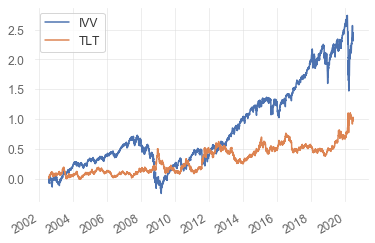

In [8]:
#plotting prices
ivv_tlt_prices.plot()

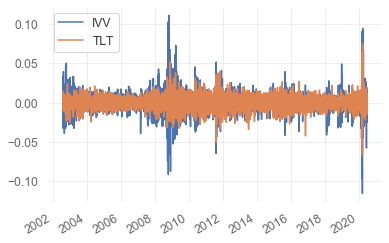

In [9]:
ivv_tlt_price_returns = get_list_hist_price_returns(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_price_returns = ivv_tlt_price_returns.dropna()
ivv_tlt_price_returns.plot()

<p>As far as price returns it seems like SPY is a better investment from a return perspective</p>

In [10]:
ivv_tlt_total_returns = get_list_hist_total_returns(['IVV','TLT'], '1989-12-31', datetime.now().strftime("%Y-%m-%d"), 'daily')
ivv_tlt_total_returns = ivv_tlt_total_returns.add_suffix('_Return')

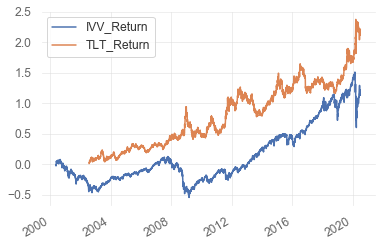

In [11]:
((ivv_tlt_total_returns[['IVV_Return','TLT_Return']] + 1).cumprod(skipna=True)-1).plot()

<h1>Final Portfolio</h1>
<h2>Minimum Variance Portfolio with a Exp. Covariance Matrix Span = 77</h2>

In [23]:
dates = daterange(date(2003, 12, 31), date(2020, 6, 29))
weights = pd.DataFrame()
for d in dates:
    prices = prices_from_returns(ivv_tlt_price_returns[ivv_tlt_price_returns.index<d])
    cov = exp_cov(prices,span=77,frequency=252)
    ef = EfficientFrontier(expected_returns=[0,0],cov_matrix=cov, weight_bounds=(0, .90)) 
    day_weights = ef.min_volatility() 
    weights = weights.append(pd.DataFrame.from_dict(day_weights,orient='index',columns=[d+timedelta(days=1)]).T)
weights = weights.add_suffix('_Weight')
weights_total_returns = ivv_tlt_total_returns.merge(weights,how='inner', left_index=True, right_index=True)
weights_total_returns['Portfolio_Return'] = weights_total_returns['IVV_Return'] * weights_total_returns['IVV_Weight'] + weights_total_returns['TLT_Return'] * weights_total_returns['TLT_Weight']

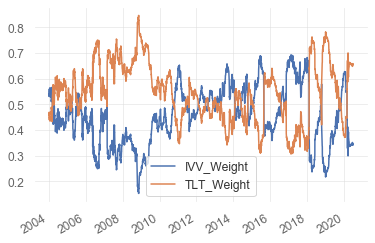

In [24]:
weights_total_returns[['IVV_Weight','TLT_Weight']].plot()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-06-26  2020-06-26
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          265.67%     177.99%
CAGR%                      8.18%       6.4%
Sharpe                     0.99        0.42
Sortino                    1.4         0.57
Max Drawdown               -19.2%      -59.34%
Longest DD Days            630         2043
Volatility (ann.)          8.28%       19.22%
R^2                        0.17        0.17
Calmar                     0.43        0.11
Skew                       -0.58       -0.55
Kurtosis                   8.46        13.92

Expected Daily %           0.03%       0.02%
Expected Monthly %         0.66%       0.52%
Expected Yearly %          7.93%       6.2%
Kelly Criterion            6.56%       2.02%
Risk of Ruin               0.0%    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-22,630,-19.203125,-18.241104
2,2020-03-09,2020-03-18,2020-04-29,51,-15.776697,-14.193208
3,2007-12-04,2008-11-13,2008-12-04,366,-12.879180,-12.217157
4,2015-03-23,2015-08-25,2016-04-06,380,-8.565984,-8.222451
5,2004-03-08,2004-05-10,2004-11-04,241,-8.282755,-7.959752


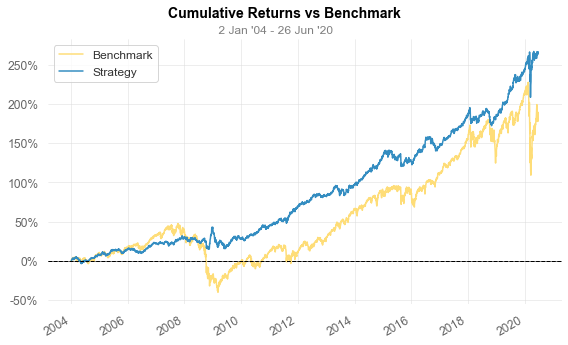

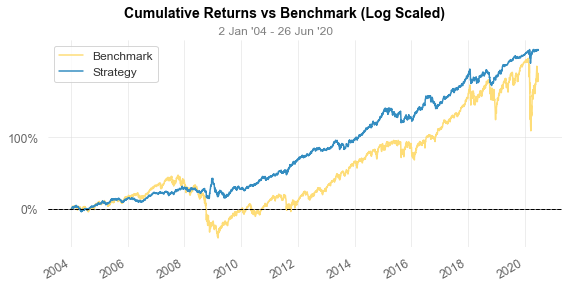

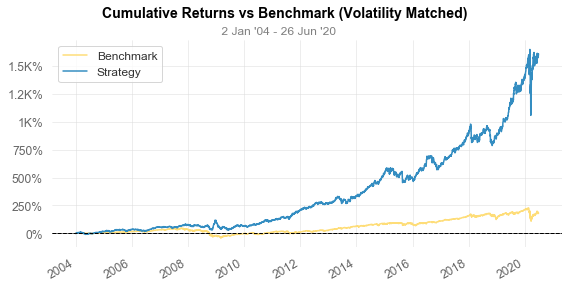

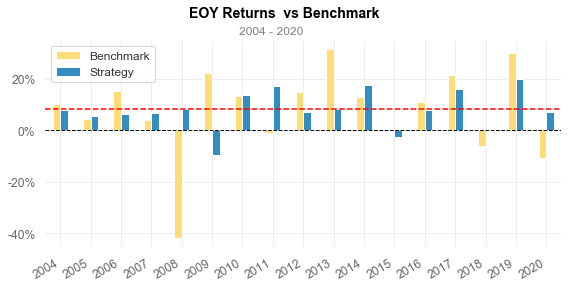

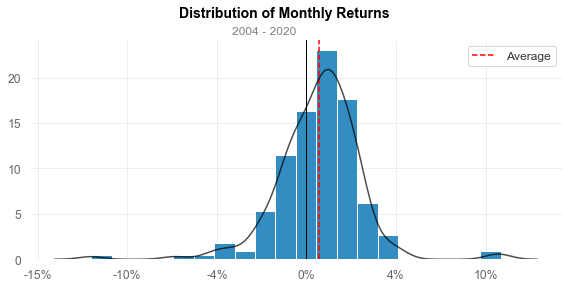

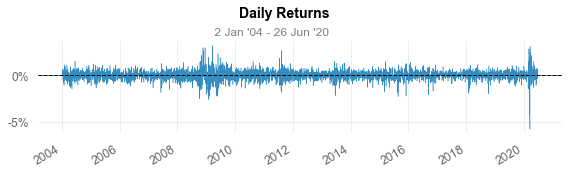

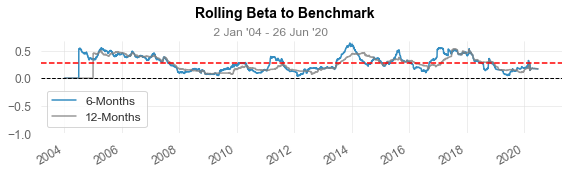

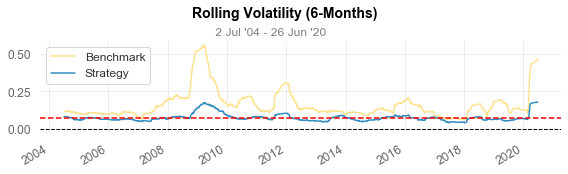

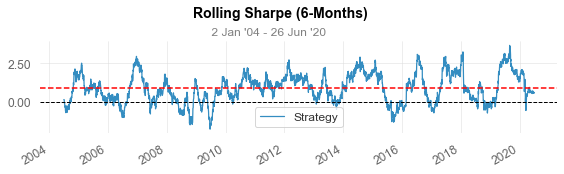

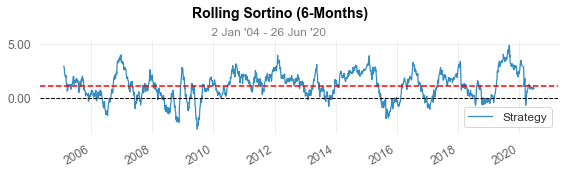

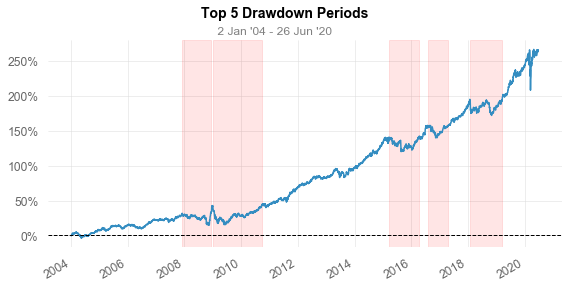

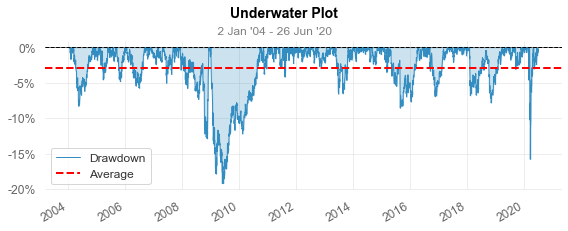

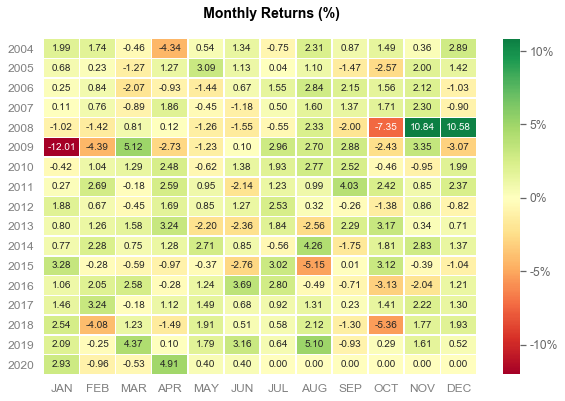

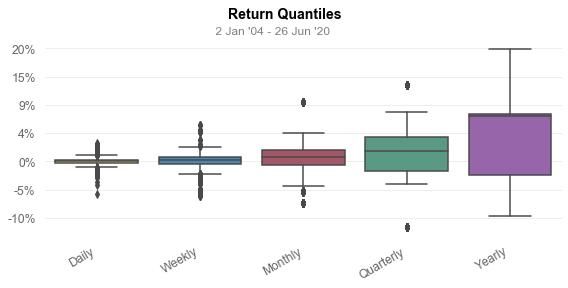

In [25]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['IVV_Return'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-02  2004-01-02
End Period                 2020-06-26  2020-06-26
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          265.67%     188.16%
CAGR%                      8.18%       6.63%
Sharpe                     0.99        0.53
Sortino                    1.4         0.76
Max Drawdown               -19.2%      -27.37%
Longest DD Days            630         1116
Volatility (ann.)          8.28%       14.05%
R^2                        0.33        0.33
Calmar                     0.43        0.24
Skew                       -0.58       0.01
Kurtosis                   8.46        4.94

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.66%       0.54%
Expected Yearly %          7.93%       6.42%
Kelly Criterion            9.16%       -0.38%
Risk of Ruin               0.0%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-05-27,2010-09-22,630,-19.203125,-18.241104
2,2020-03-09,2020-03-18,2020-04-29,51,-15.776697,-14.193208
3,2007-12-04,2008-11-13,2008-12-04,366,-12.879180,-12.217157
4,2015-03-23,2015-08-25,2016-04-06,380,-8.565984,-8.222451
5,2004-03-08,2004-05-10,2004-11-04,241,-8.282755,-7.959752


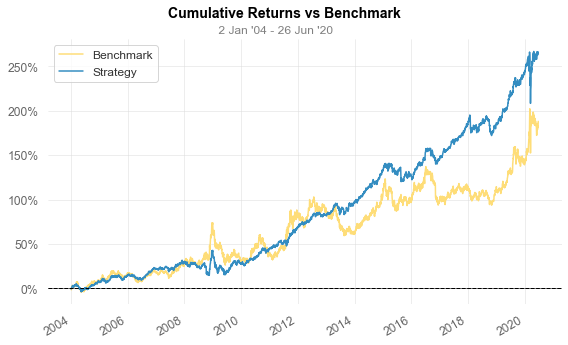

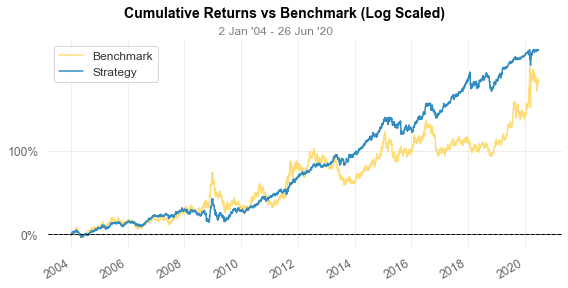

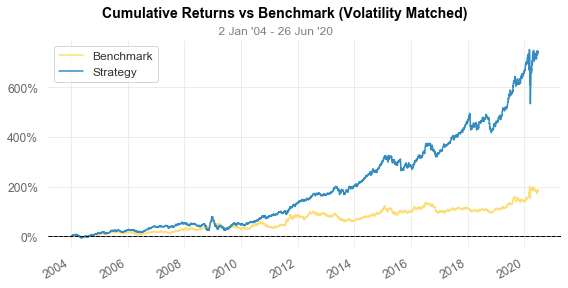

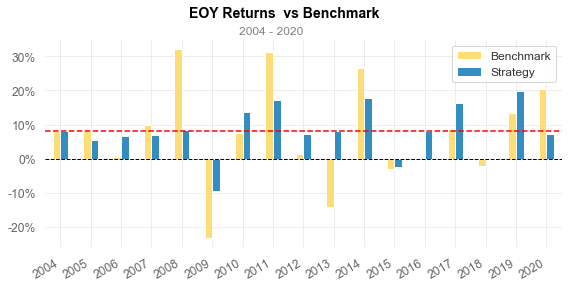

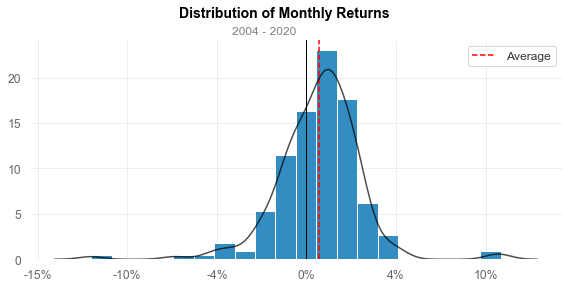

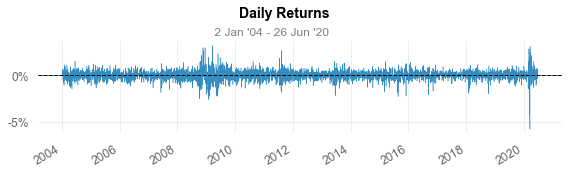

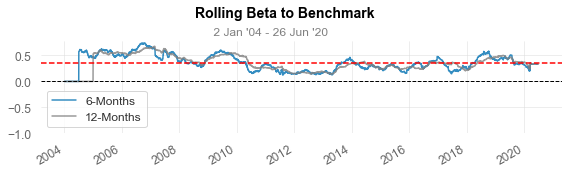

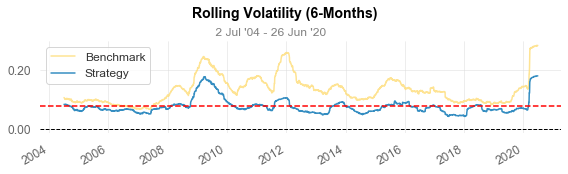

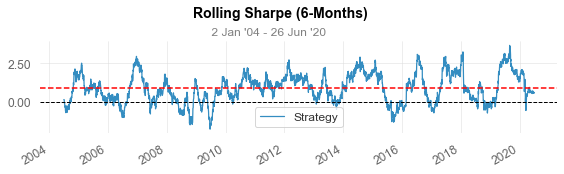

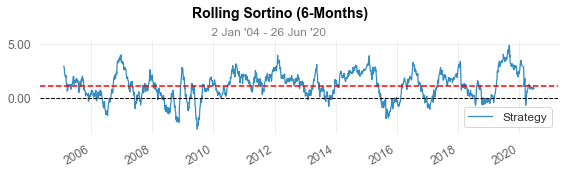

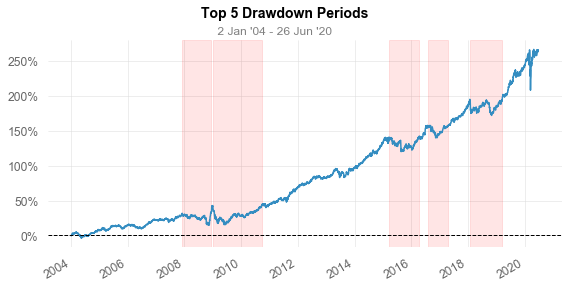

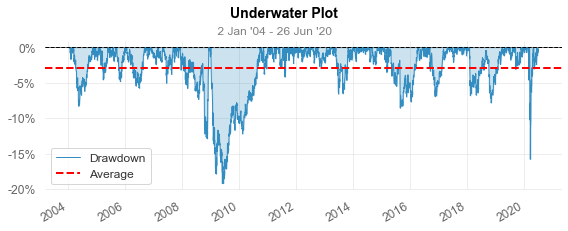

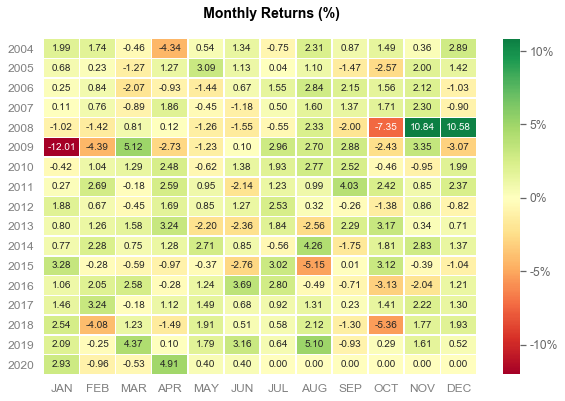

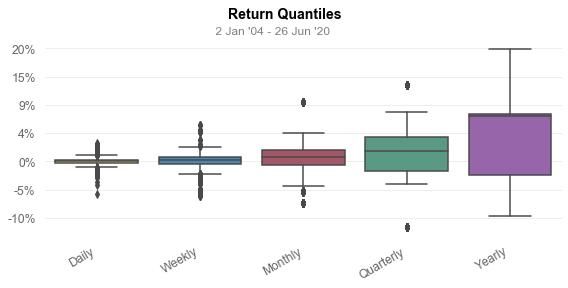

In [26]:
qs.reports.full(returns=weights_total_returns['Portfolio_Return'],benchmark=weights_total_returns['TLT_Return'])